<a href="https://colab.research.google.com/github/sardarmoneeb/Machine-Learning/blob/main/Fake_and_Real_Reviews_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# {"username":"sardarsab","key":"aeb0ef366b1da2f879943031be60e93f"}

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Optional – if you want to save models or results to Drive


Mounted at /content/drive


In [3]:
!pip install opendatasets


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/mexwell/fake-reviews-dataset'
target_path = '/content/drive/MyDrive/fake-reviews-dataset'

od.download(dataset_url, data_dir=target_path)

Skipping, found downloaded files in "/content/drive/MyDrive/fake-reviews-dataset/fake-reviews-dataset" (use force=True to force download)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!ls "/content/drive/MyDrive/fake-reviews-dataset/fake-reviews-dataset/"


'fake reviews dataset.csv'


In [16]:
import pandas as pd

# Mount drive (if not already)
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/fake-reviews-dataset/fake-reviews-dataset/fake reviews dataset.csv')

# Show first few rows
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [17]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
df.columns


Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# -----------------------------
# 1. Text Cleaning Function
# -----------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', ' ', text)
    # Remove special characters, numbers, punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# -----------------------------
# 2. Preprocessing Function (Clean + Remove Stopwords + Lemmatize)
# -----------------------------
def preprocess_text(text):
    text = clean_text(text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# -----------------------------
# 3. Apply Preprocessing
# -----------------------------
print("Starting preprocessing...")
df['cleaned_text'] = df['text_'].apply(preprocess_text)

# Drop rows where cleaned_text is empty
df = df[df['cleaned_text'].str.strip() != ''].reset_index(drop=True)

print(f"After preprocessing: {len(df)} reviews remain")
print("\nSample cleaned reviews:")
print(df[['text_', 'cleaned_text']].head(3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Starting preprocessing...
After preprocessing: 40431 reviews remain

Sample cleaned reviews:
                                               text_  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   

                                    cleaned_text  
0  love well made sturdy comfortable love pretty  
1   love great upgrade original mine couple year  
2        pillow saved back love look feel pillow  


In [21]:
# After your preprocessing cell
print(df[['text_', 'cleaned_text', 'label']].head())
print("\nLabel distribution:")
print(df['label'].value_counts())

                                               text_  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   
3  Missing information on how to use it, but it i...   
4  Very nice set. Good quality. We have had the s...   

                                    cleaned_text label  
0  love well made sturdy comfortable love pretty    CG  
1   love great upgrade original mine couple year    CG  
2        pillow saved back love look feel pillow    CG  
3    missing information use great product price    CG  
4            nice set good quality set two month    CG  

Label distribution:
label
OR    20216
CG    20215
Name: count, dtype: int64


In [22]:
# Map CG → 1 (fake), OR → 0 (real)
df['target'] = df['label'].map({'CG': 1, 'OR': 0})
y = df['target']

In [23]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 32344, Test: 8087


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10_000,      # keep top 10 k terms
    ngram_range=(1, 2),       # unigrams + bigrams
    min_df=2,                 # ignore very rare words
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print(f"TF-IDF shape → {X_train_tfidf.shape}")

TF-IDF shape → (32344, 10000)


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
def evaluate(model, name):
    model.fit(X_train_tfidf, y_train)
    pred = model.predict(X_test_tfidf)
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_test, pred))
    print(classification_report(y_test, pred, target_names=['Real (OR)', 'Fake (CG)']))


=== Logistic Regression ===
Accuracy : 0.8848769630270805
              precision    recall  f1-score   support

   Real (OR)       0.88      0.89      0.89      4044
   Fake (CG)       0.89      0.88      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.89      0.88      0.88      8087
weighted avg       0.89      0.88      0.88      8087



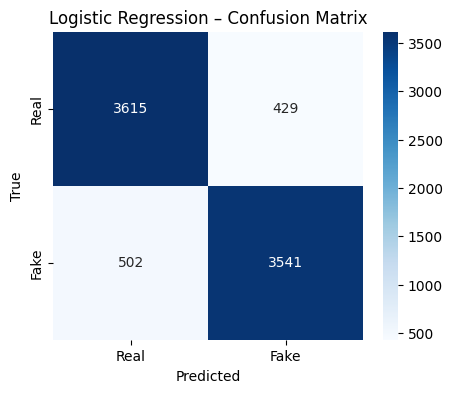


=== Multinomial Naive Bayes ===
Accuracy : 0.8659577099047855
              precision    recall  f1-score   support

   Real (OR)       0.86      0.88      0.87      4044
   Fake (CG)       0.87      0.86      0.86      4043

    accuracy                           0.87      8087
   macro avg       0.87      0.87      0.87      8087
weighted avg       0.87      0.87      0.87      8087



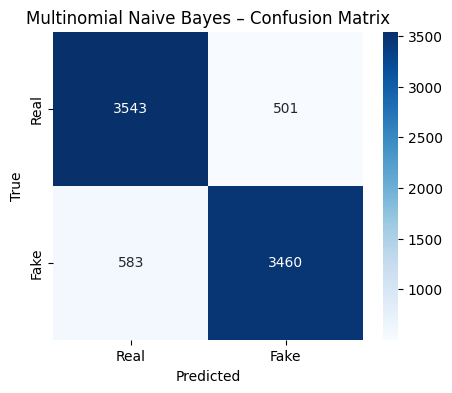


=== Linear SVM ===
Accuracy : 0.8883393100037097
              precision    recall  f1-score   support

   Real (OR)       0.89      0.89      0.89      4044
   Fake (CG)       0.89      0.89      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



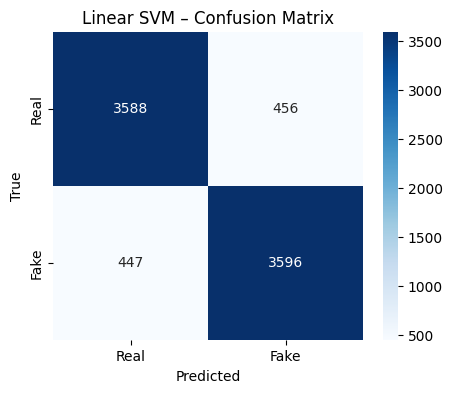

✅ All models trained, evaluated, and saved successfully!


In [65]:
# -------------------------------------------------
# Train and Save Models Using evaluate()
# -------------------------------------------------

# 1️⃣ Logistic Regression
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
evaluate(model_lr, 'Logistic Regression')

# 2️⃣ Naive Bayes
model_nb = MultinomialNB()
evaluate(model_nb, 'Multinomial Naive Bayes')

# 3️⃣ Linear SVM
model_svm = LinearSVC(class_weight='balanced', max_iter=2000)
evaluate(model_svm, 'Linear SVM')

print("✅ All models trained, evaluated, and saved successfully!")


In [54]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/joebeachcapital/recipe-reviews-and-user-feedback-dataset'
target_path = '/content/drive/MyDrive/recipe-reviews-and-user-feedback-dataset'

od.download(dataset_url, data_dir=target_path)

Skipping, found downloaded files in "/content/drive/MyDrive/recipe-reviews-and-user-feedback-dataset/recipe-reviews-and-user-feedback-dataset" (use force=True to force download)


In [55]:
!ls "/content/drive/MyDrive/recipe-reviews-and-user-feedback-dataset/recipe-reviews-and-user-feedback-dataset/"


'Recipe Reviews and User Feedback Dataset.csv'


In [56]:
df.columns


Index(['Unnamed: 0', 'recipe_number', 'recipe_code', 'recipe_name',
       'comment_id', 'user_id', 'user_name', 'user_reputation', 'created_at',
       'reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score',
       'text'],
      dtype='object')

In [57]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
import pandas as pd

# Load dataset from Google Drive
recipe_path = '/content/drive/MyDrive/recipe-reviews-and-user-feedback-dataset/recipe-reviews-and-user-feedback-dataset/Recipe Reviews and User Feedback Dataset.csv'

recipe_df = pd.read_csv(recipe_path)

# Check basic info
print("Shape:", recipe_df.shape)
print("Columns:", recipe_df.columns)
recipe_df.head()


Shape: (18182, 15)
Columns: Index(['Unnamed: 0', 'recipe_number', 'recipe_code', 'recipe_name',
       'comment_id', 'user_id', 'user_name', 'user_reputation', 'created_at',
       'reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score',
       'text'],
      dtype='object')


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [59]:
# Drop nulls before cleaning
recipe_df = recipe_df.dropna(subset=['text']).copy()

# Apply cleaning
recipe_df['cleaned_text'] = recipe_df['text'].apply(clean_text)

# Drop empty results (if any)
recipe_df = recipe_df[recipe_df['cleaned_text'].str.strip() != '']

print("After cleaning:", recipe_df.shape)
recipe_df[['text','cleaned_text']].head()


After cleaning: (18164, 16)


,text,cleaned_text
0,"I tweaked it a little, removed onions because ...",tweaked little removed onions onion haters hou...
1,Bush used to have a white chili bean and it ma...,bush used white chili bean made recipe super s...
2,I have a very complicated white chicken chili ...,complicated white chicken chili recipe made ye...
3,"In your introduction, you mentioned cream chee...",introduction mentioned cream cheese none liste...
4,Wonderful! I made this for a &#34;Chili/Stew&#...,wonderful made chili stew night dinner church ...


In [60]:
# Transform cleaned text using the same TF-IDF vectorizer you used earlier
X_recipe = vectorizer.transform(recipe_df['cleaned_text']).toarray()
print("Vectorized recipe data shape:", X_recipe.shape)


Vectorized recipe data shape: (18164, 10000)


In [61]:
# Transform recipe reviews using the same TF-IDF vectorizer
X_recipe = vectorizer.transform(recipe_df['cleaned_text']).toarray()
print("Vectorized recipe dataset shape:", X_recipe.shape)


Vectorized recipe dataset shape: (18164, 10000)


In [67]:
# Predict labels on Recipe reviews using trained models
recipe_df['pred_lr']  = model_lr.predict(X_recipe)
recipe_df['pred_nb']  = model_nb.predict(X_recipe)
recipe_df['pred_svm'] = model_svm.predict(X_recipe)

print("✅ Predictions done successfully on Recipe dataset!")


✅ Predictions done successfully on Recipe dataset!


In [68]:
# Show sample results
recipe_df[['text', 'pred_lr', 'pred_nb', 'pred_svm']].head(10)


,text,pred_lr,pred_nb,pred_svm
0,"I tweaked it a little, removed onions because ...",0,0,0
1,Bush used to have a white chili bean and it ma...,0,0,0
2,I have a very complicated white chicken chili ...,0,0,0
3,"In your introduction, you mentioned cream chee...",0,0,0
4,Wonderful! I made this for a &#34;Chili/Stew&#...,0,0,0
5,amazing! my boyfriend loved it so much! going ...,0,0,1
6,Wow!!! This recipe is excellent as written!! ...,0,0,0
7,This is delicious and I make it often. One suc...,0,0,0
8,I absolutely love this recipe. I&#39;ve tweake...,0,0,0
9,I make this a lot … my kids and there friends ...,0,0,0


/tmp/ipython-input-2594887875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pred_lr', data=recipe_df, palette='coolwarm')


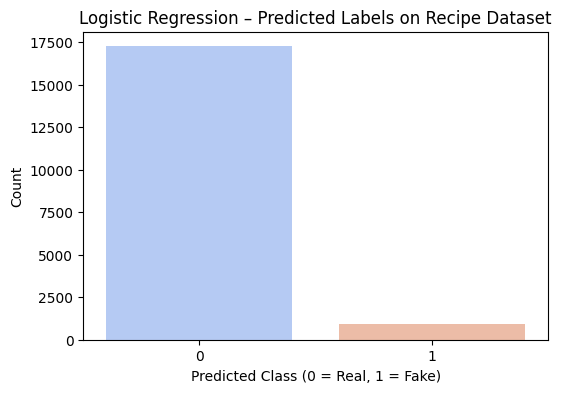

Prediction counts:
pred_lr
0    17264
1      900
Name: count, dtype: int64


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='pred_lr', data=recipe_df, palette='coolwarm')
plt.title('Logistic Regression – Predicted Labels on Recipe Dataset')
plt.xlabel('Predicted Class (0 = Real, 1 = Fake)')
plt.ylabel('Count')
plt.show()

print("Prediction counts:")
print(recipe_df['pred_lr'].value_counts())


In [70]:
recipe_df['agreement'] = (
    (recipe_df['pred_lr'] == recipe_df['pred_nb']) &
    (recipe_df['pred_nb'] == recipe_df['pred_svm'])
)

agreement_rate = recipe_df['agreement'].mean()
print(f"🧮 Models agree on {agreement_rate*100:.2f}% of recipe reviews.")


🧮 Models agree on 91.66% of recipe reviews.


In [71]:
# ------------- Save models, vectorizer, and processed data -------------
import os
import joblib
import pandas as pd

# Paths (change if you want)
BASE = '/content/drive/MyDrive/fake_review_models/'     # models + vectorizer
DATA_SAVE = '/content/drive/MyDrive/fake_review_data/'  # processed datasets & predictions

os.makedirs(BASE, exist_ok=True)
os.makedirs(DATA_SAVE, exist_ok=True)

# 1) Save models (must exist in memory: model_lr, model_nb, model_svm)
joblib.dump(model_lr,  os.path.join(BASE, 'model_logistic.pkl'))
joblib.dump(model_nb,  os.path.join(BASE, 'model_nb.pkl'))
joblib.dump(model_svm, os.path.join(BASE, 'model_svm.pkl'))

# 2) Save TF-IDF vectorizer (must exist in memory: vectorizer)
joblib.dump(vectorizer, os.path.join(BASE, 'tfidf_vectorizer.pkl'))

# 3) Save preprocessed fake dataset (df_fake should have cleaned_text and label)
#    Save as CSV + pickle (pickle keeps dtypes)
df_fake.to_csv(os.path.join(DATA_SAVE, 'df_fake_cleaned.csv'), index=False)
df_fake.to_pickle(os.path.join(DATA_SAVE, 'df_fake_cleaned.pkl'))

# 4) Save preprocessed recipe dataset (recipe_df should have cleaned_text and predictions)
recipe_df.to_csv(os.path.join(DATA_SAVE, 'recipe_cleaned_with_preds.csv'), index=False)
recipe_df.to_pickle(os.path.join(DATA_SAVE, 'recipe_cleaned_with_preds.pkl'))

print("✅ Saved models and processed datasets to Drive:")
print(" Models & vectorizer ->", BASE)
print(" Data files ->", DATA_SAVE)


NameError: name 'df_fake' is not defined